In [20]:
dataset_path = r"archive\Driver Drowsiness Dataset (DDD)"

In [21]:
import os
import cv2
import numpy as np
import mediapipe as mp
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [22]:
mp_face_mesh = mp.solutions.face_mesh

# 取 Face Mesh 中左右眼的 6 个关键点索引
LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]
# 嘴部关键点（左右口角、上唇、下唇）
MOUTH_IDX = {"left": 78, "right": 308, "upper": 13, "lower": 14}

# 增加眉毛关键点索引 (左眉毛中间, 右眉毛中间)
# 左眉毛中间点: 66, 左眼上边缘中间点: 159
# 右眉毛中间点: 296, 右眼上边缘中间点: 386
LEFT_EYEBROW_MID = 66
LEFT_EYE_TOP = 159
RIGHT_EYEBROW_MID = 296
RIGHT_EYE_TOP = 386

In [23]:
def eye_aspect_ratio(pts):
    # pts: (6,2)
    A = np.linalg.norm(pts[1] - pts[5])
    B = np.linalg.norm(pts[2] - pts[4])
    C = np.linalg.norm(pts[0] - pts[3])
    return (A + B) / (2.0 * C + 1e-6)


def eye_circularity(pts):
    # 眼睛面积 / (周长^2) * 4*pi，或者简单用 A+B (高度) / C (宽度) 类似 EAR，
    # 这里我们用一个简单的变体：眼睛周长
    perimeter = (
        np.linalg.norm(pts[0] - pts[1])
        + np.linalg.norm(pts[1] - pts[2])
        + np.linalg.norm(pts[2] - pts[3])
        + np.linalg.norm(pts[3] - pts[4])
        + np.linalg.norm(pts[4] - pts[5])
        + np.linalg.norm(pts[5] - pts[0])
    )
    # 面积近似 (EAR公式里的分子其实代表了高度和)
    height = (
        np.linalg.norm(pts[1] - pts[5])
        + np.linalg.norm(pts[2] - pts[4])
    ) / 2
    width = np.linalg.norm(pts[0] - pts[3])
    area = np.pi * (height / 2) * (width / 2)
    return (4 * np.pi * area) / (perimeter**2 + 1e-6)


def mouth_aspect_ratio(lm, h, w):
    l = np.array([lm[MOUTH_IDX["left"]].x * w, lm[MOUTH_IDX["left"]].y * h])
    r = np.array([lm[MOUTH_IDX["right"]].x * w, lm[MOUTH_IDX["right"]].y * h])
    u = np.array([lm[MOUTH_IDX["upper"]].x * w, lm[MOUTH_IDX["upper"]].y * h])
    d = np.array([lm[MOUTH_IDX["lower"]].x * w, lm[MOUTH_IDX["lower"]].y * h])
    horizontal = np.linalg.norm(l - r)
    vertical = np.linalg.norm(u - d)
    return vertical / (horizontal + 1e-6)

def compute_features_optimized(img_path, face_mesh):
    img = cv2.imread(img_path)
    if img is None:
        return None

    # 转换颜色空间
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = rgb.shape[:2]

    # 使用传入的 face_mesh 对象
    res = face_mesh.process(rgb)

    if not res.multi_face_landmarks:
        return None

    lm = res.multi_face_landmarks[0].landmark

    # 定义内部获取点的函数
    def get_pts(idx_list):
        return np.array(
            [[lm[i].x * w, lm[i].y * h] for i in idx_list], dtype=np.float32
        )
    
    # 获取单个点的坐标
    def get_pt(idx):
        return np.array([lm[idx].x * w, lm[idx].y * h], dtype=np.float32)

    # 1. EAR
    left_pts = get_pts(LEFT_EYE)
    right_pts = get_pts(RIGHT_EYE)
    left_ear = eye_aspect_ratio(left_pts)
    right_ear = eye_aspect_ratio(right_pts)
    ear = float((left_ear + right_ear) / 2.0)

    # 2. MAR
    mar = float(mouth_aspect_ratio(lm, h, w))

    # 3. Circularity
    left_circ = eye_circularity(left_pts)
    right_circ = eye_circularity(right_pts)
    circ = float((left_circ + right_circ) / 2.0)
    
    # 4. Eye-Eyebrow Distance (归一化)
    # 计算左眼眉毛距离
    l_brow = get_pt(LEFT_EYEBROW_MID)
    l_eye = get_pt(LEFT_EYE_TOP)
    l_dist = np.linalg.norm(l_brow - l_eye)
    
    # 计算右眼眉毛距离
    r_brow = get_pt(RIGHT_EYEBROW_MID)
    r_eye = get_pt(RIGHT_EYE_TOP)
    r_dist = np.linalg.norm(r_brow - r_eye)
    
    # 归一化：除以眼睛的宽度，避免人脸远近的影响
    l_eye_width = np.linalg.norm(left_pts[0] - left_pts[3])
    r_eye_width = np.linalg.norm(right_pts[0] - right_pts[3])
    
    brow_dist = (l_dist / (l_eye_width + 1e-6) + r_dist / (r_eye_width + 1e-6)) / 2.0

    # 返回 4 个特征
    return [ear, mar, circ, brow_dist]

In [24]:
from tqdm import tqdm

def load_ear_mar_dataset(root_dir):
    X, y = [], []

    # 1. 先收集所有文件路径，方便显示进度条
    all_files = []
    for cls in os.listdir(root_dir):
        cls_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        label = 0 if "non" in cls.lower() else 1
        for fname in os.listdir(cls_dir):
            all_files.append((os.path.join(cls_dir, fname), label))

    print(
        f"Found {len(all_files)} images. Processing sequentially with optimized model..."
    )

    # 2. 在循环外只初始化一次模型！这是速度提升 100 倍的关键
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5,
    ) as fm:
        # 使用 tqdm 显示进度
        for fpath, label in tqdm(all_files):
            feat = compute_features_optimized(fpath, fm)
            if feat is not None:
                X.append(feat)
                y.append(label)

    return np.array(X), np.array(y)

In [25]:
X, y = load_ear_mar_dataset(dataset_path)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

Found 41793 images. Processing sequentially with optimized model...


100%|██████████| 41793/41793 [04:02<00:00, 172.66it/s]

Train samples: 33420, Test samples: 8356


In [27]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

print("Random Forest Train Accuracy:", accuracy_score(y_train, train_pred))
print("Random Forest Test Accuracy:", accuracy_score(y_test, test_pred))
print("Classification report (test):\n", classification_report(y_test, test_pred))
print("Confusion matrix (test):\n", confusion_matrix(y_test, test_pred))

Random Forest Train Accuracy: 1.0
Random Forest Test Accuracy: 0.8227620871230253
Classification report (test):
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      3888
           1       0.84      0.83      0.83      4468

    accuracy                           0.82      8356
   macro avg       0.82      0.82      0.82      8356
weighted avg       0.82      0.82      0.82      8356

Confusion matrix (test):
 [[3166  722]
 [ 759 3709]]


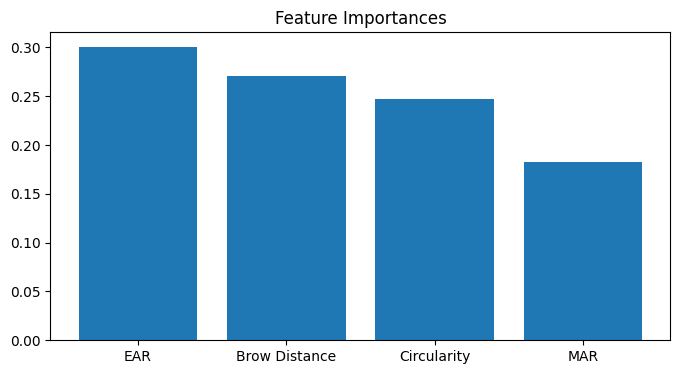

In [28]:
# 查看特征重要性
feature_names = ["EAR", "MAR", "Circularity", "Brow Distance"]
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices])
plt.show()